<a href="https://colab.research.google.com/github/mecatronico-consultor/rev2-ppg-bgl-estimation-using-mfcc-features/blob/main/must_ppg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install librosa scikit-learn pandas scipy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
import librosa
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

Buscando Total.csv en: /content/drive/MyDrive/Colab Notebooks/MUST PPG ...
¡Archivo cargado exitosamente!

--- Rango de Valores (Mínimo y Máximo) ---
     Age  Glucose  Height  Weight
min   22       88     154      42
max   61      183     187     103
----------------------------------------


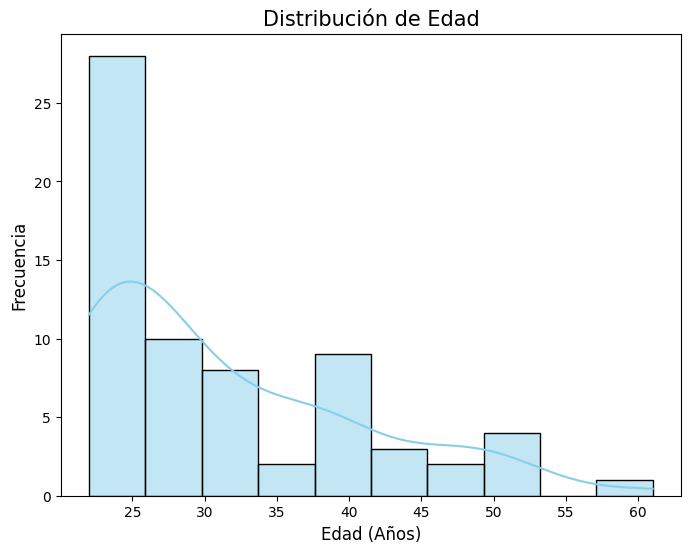

--------------------------------------------------


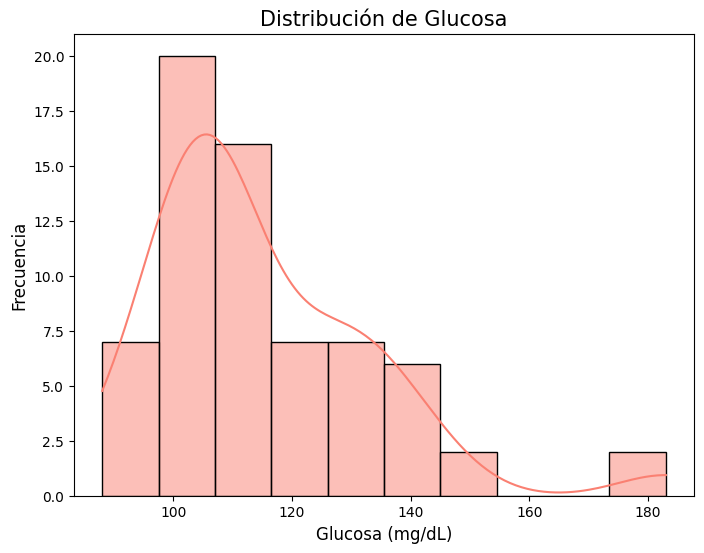

--------------------------------------------------


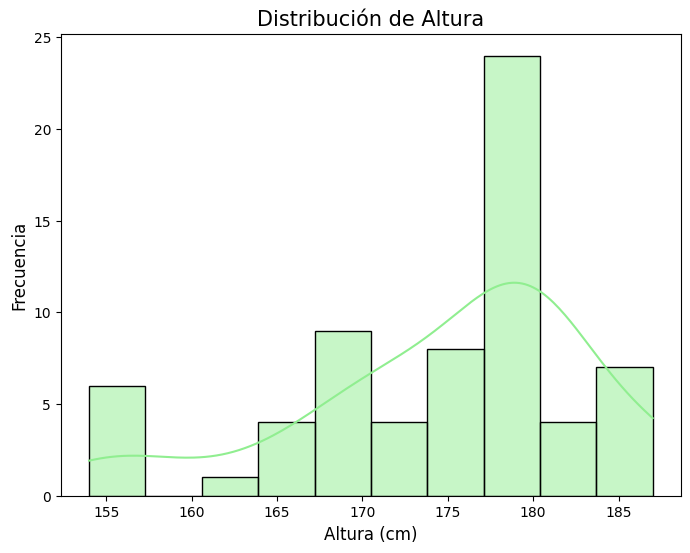

--------------------------------------------------


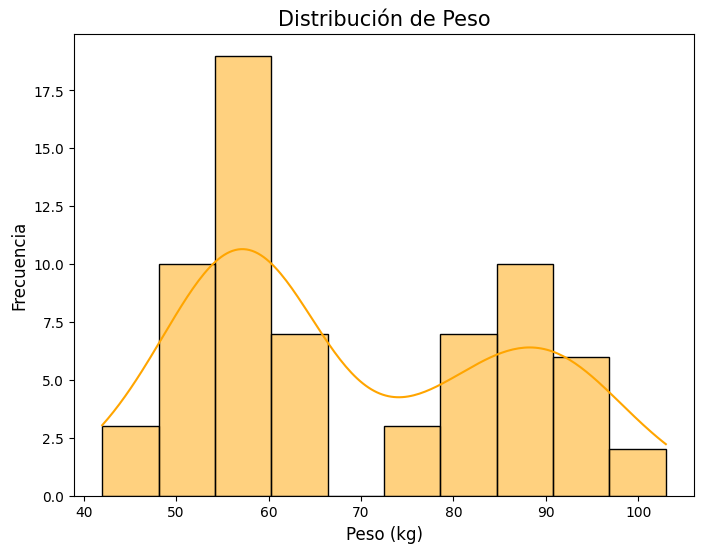

--------------------------------------------------


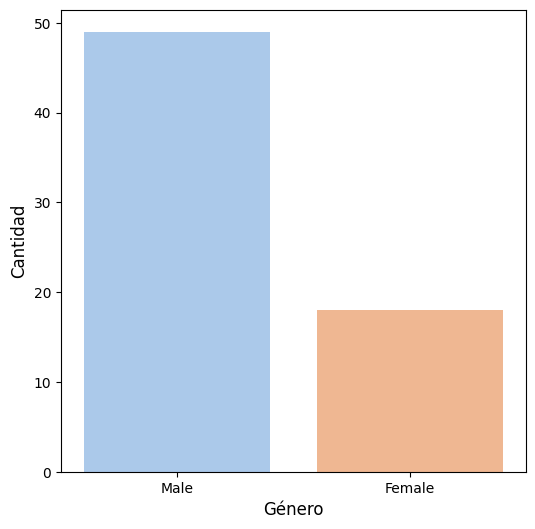

--------------------------------------------------


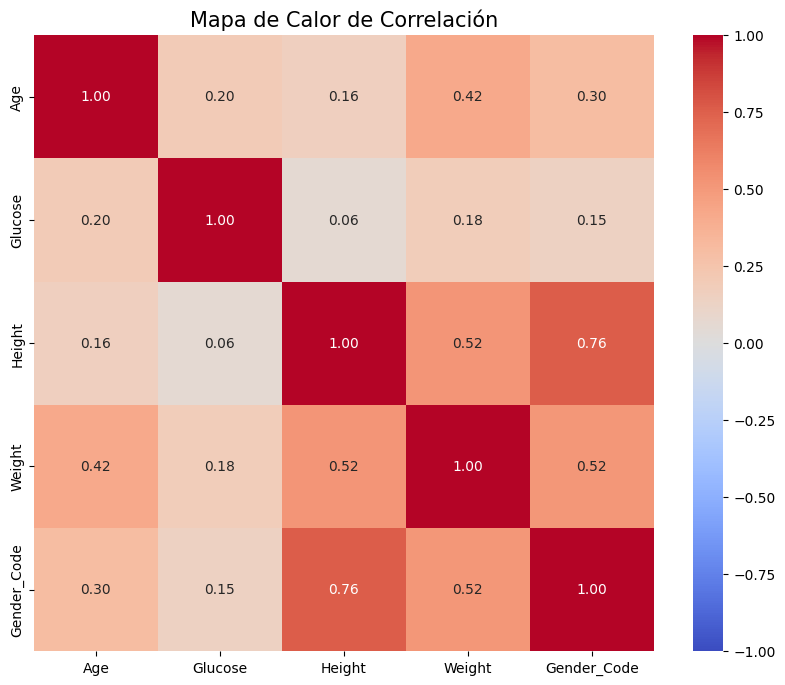

In [5]:
# ==========================================
# ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ==========================================
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

RUTA_EN_DRIVE = '/content/drive/MyDrive/Colab Notebooks/MUST PPG'
archivo_total = os.path.join(RUTA_EN_DRIVE, 'Total.csv')

print(f"Buscando Total.csv en: {RUTA_EN_DRIVE} ...")

#Cargar y Analizar
if os.path.exists(archivo_total):
    df = pd.read_csv(archivo_total)
    print("¡Archivo cargado exitosamente!\n")

    # --- A. VALORES MÍNIMOS Y MÁXIMOS ---
    print("--- Rango de Valores (Mínimo y Máximo) ---")
    variables_numericas = ['Age', 'Glucose', 'Height', 'Weight']
    # Extraemos min y max de forma limpia
    resumen = df[variables_numericas].agg(['min', 'max'])
    print(resumen)
    print("-" * 40)

    # --- B. GRAFICACIÓN ---
    # Configuración estética
    #sns.set(style="whitegrid")
    #plt.figure(figsize=(18, 10))


    # Gráfica 1: Distribución de Edad
    plt.figure(figsize=(8,6))
    #plt.subplot(2, 3, 1)
    sns.histplot(df['Age'], kde=True, bins=10, color='skyblue')
    #plt.title('Distribución de Edad')
    #plt.xlabel('Edad (Años)')
    plt.title('Distribución de Edad', fontsize=15)
    plt.xlabel('Edad (Años)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.show() # <--- Esto "cierra" la gráfica y la muestra sola
    print("-" * 50) # Separador visual

    # Gráfica 2: Distribución de Glucosa (Target)
    #plt.subplot(2, 3, 2)
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Glucose'], kde=True, bins=10, color='salmon')
    #plt.title('Distribución de Glucosa')
    #plt.xlabel('Glucosa (mg/dL)')
    plt.title('Distribución de Glucosa', fontsize=15)
    plt.xlabel('Glucosa (mg/dL)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.show()
    print("-" * 50)

    # Gráfica 3: Distribución de Altura
    #plt.subplot(2, 3, 3)
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Height'], kde=True, bins=10, color='lightgreen')
    #plt.title('Distribución de Altura')
    #plt.xlabel('Altura (cm)')
    plt.title('Distribución de Altura', fontsize=15)
    plt.xlabel('Altura (cm)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.show()
    print("-" * 50)

    # Gráfica 4: Distribución de Peso
    #plt.subplot(2, 3, 4)
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Weight'], kde=True, bins=10, color='orange')
    #plt.title('Distribución de Peso')
    #plt.xlabel('Peso (kg)')
    plt.title('Distribución de Peso', fontsize=15)
    plt.xlabel('Peso (kg)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.show()
    print("-" * 50)

    # Gráfica 5: Conteo por Género
    #plt.subplot(2, 3, 5)
    plt.figure(figsize=(6, 6))
    sns.countplot(x='Gender', data=df, palette='pastel', hue='Gender')
    #plt.title('Distribución por Género')
    plt.xlabel('Género', fontsize=12)
    plt.ylabel('Cantidad', fontsize=12)
    plt.show()
    print("-" * 50)

    # Gráfica 6: Mapa de Calor de Correlación
    #plt.subplot(2, 3, 6)
    plt.figure(figsize=(10, 8))
    # Copiamos y convertimos género a número (Male=0, Female=1) para ver si influye
    df_corr = df.copy()
    # Detectamos si la columna es texto y la convertimos
    if df_corr['Gender'].dtype == 'object':
        df_corr['Gender_Code'] = df_corr['Gender'].astype('category').cat.codes
    else:
        df_corr['Gender_Code'] = df_corr['Gender']

    # Seleccionamos solo columnas numéricas para correlación
    cols_corr = ['Age', 'Glucose', 'Height', 'Weight', 'Gender_Code']
    matriz_corr = df_corr[cols_corr].corr()

    sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    #plt.title('Mapa de Calor de Correlación')
    #plt.tight_layout()
    #plt.show()
    plt.title('Mapa de Calor de Correlación', fontsize=15)
    plt.show()

else:
    print(f"❌ ERROR: No se encontró el archivo en {archivo_total}")
    print("Verifica que el nombre de la carpeta sea exacto (espacios y mayúsculas importan).")

In [6]:
# ==========================================
# CELDA 2: CONFIGURACIÓN de parámetros
# ==========================================

# Frecuencia de muestreo del sensor (Hz).
# El paper usa 2175 Hz[cite: 327]. A esta frecuencia el sensor adquirió las señales
FS = 2175

#Parámetros del método SDFMFCC [cite: 263-267]
WINDOW_EXT_MS = 20  # Extensión de la ventana en ms a cada lado de los picos [cite: 158]
MFCC_COEFFS = 12    # Número de coeficientes cepstrales [cite: 264]
N_MELS = 20         # Número de bancos de filtros Mel [cite: 263]
FREQ_MIN = 1        # Frecuencia mínima en Hz [cite: 266]
FREQ_MAX = 4.5      # Frecuencia máxima en Hz (rango PPG) [cite: 266]

print(f"Configuración cargada: FS={FS}Hz, MFCC={MFCC_COEFFS}")

Configuración cargada: FS=2175Hz, MFCC=12


In [7]:
# ==========================================
# CELDA 3: FUNCIÓN DE EXTRACCIÓN
# ==========================================
import warnings

def extract_sdfmfcc_features(signal_values, fs):
    """
    Versión mejorada con alta resolución espectral (Zero-Padding)
    para evitar el error 'Empty filters' en rangos de baja frecuencia.
    """
    # 1. Suavizado (Savitzky-Golay)
    window_length = 15
    polyorder = 3
    try:
        smooth_signal = savgol_filter(signal_values, window_length=window_length, polyorder=polyorder)
    except ValueError:
        smooth_signal = signal_values

    # 2. Detección de Picos
    distance_samples = int(fs / 3.5) # Aprox. para evitar falsos positivos
    systolic_peaks, _ = find_peaks(smooth_signal, distance=distance_samples)
    diastolic_peaks, _ = find_peaks(-smooth_signal, distance=distance_samples)

    # 3. Framing (Segmentación)
    ext_samples = int((WINDOW_EXT_MS / 1000) * fs)
    mfcc_features_list = []

    # Unir y ordenar puntos
    all_points = []
    for p in systolic_peaks: all_points.append((p, 'S'))
    for p in diastolic_peaks: all_points.append((p, 'D'))
    all_points.sort(key=lambda x: x[0])

    # Recorrer segmentos
    for i in range(len(all_points) - 1):
        idx_curr, _ = all_points[i]
        idx_next, _ = all_points[i+1]

        start = max(0, idx_curr - ext_samples)
        end = min(len(signal_values), idx_next + ext_samples)
        segment = signal_values[start:end]

        if len(segment) < 10: continue

        # --- CORRECCIÓN CLAVE ---
        segment = segment.astype(float)

        # Usamos un n_fft MUY grande para tener resolución en 1-4.5 Hz
        # Resolución = Fs / n_fft.
        # 2175 / 16384 ≈ 0.13 Hz (suficiente para separar los 20 filtros)
        n_fft_high_res = 16384

        try:
            # Suprimimos los warnings de librosa temporalmente para limpiar la salida
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                mfccs = librosa.feature.mfcc(y=segment, sr=fs,
                                             n_mfcc=MFCC_COEFFS,
                                             n_mels=N_MELS,
                                             fmin=FREQ_MIN, fmax=FREQ_MAX,
                                             n_fft=n_fft_high_res,
                                             hop_length=len(segment)+1, # Un solo frame por segmento
                                             center=True) # Center=True ayuda con el padding

            # Tomamos la media (aunque con hop_length grande suele salir 1 columna)
            mfcc_mean = np.mean(mfccs, axis=1)

            # Validación extra: si sale todo ceros o NaNs, ignorar
            if not np.all(mfcc_mean == 0) and not np.isnan(mfcc_mean).any():
                mfcc_features_list.append(mfcc_mean)

        except Exception as e:
            # print(f"Error en segmento: {e}")
            continue

    if not mfcc_features_list:
        return np.zeros(MFCC_COEFFS)

    return np.mean(mfcc_features_list, axis=0)

print("Función SDFMFCC corregida con Alta Resolución (n_fft=16384).")

Función SDFMFCC corregida con Alta Resolución (n_fft=16384).


In [10]:
# ==========================================
# CELDA 4 CORREGIDA: CARGA DE DATOS (FIX IDs 01-09)
# ==========================================
from google.colab import drive
import os
import pandas as pd
import numpy as np

# 1. Montar Drive (si no está montado)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. DEFINIR RUTA (Ajusta esto si cambiaste la carpeta)
# Según tu diagnóstico, esta es la ruta correcta:
RUTA_EN_DRIVE = '/content/drive/MyDrive/Colab Notebooks/MUST PPG'

print(f"Buscando archivos en: {RUTA_EN_DRIVE}")

if not os.path.exists(RUTA_EN_DRIVE):
    print(f"¡ERROR! La ruta no existe.")
else:
    path_total = os.path.join(RUTA_EN_DRIVE, 'Total.csv')

    if os.path.exists(path_total):
        df_total = pd.read_csv(path_total)
        # Contador de mediciones
        df_total['measurement_num'] = df_total.groupby('ID').cumcount() + 1

        X = []
        Y = []
        found_files = 0

        print("Procesando señales...")

        for index, row in df_total.iterrows():
            p_id = row['ID']
            m_num = row['measurement_num']

            # --- CORRECCIÓN AQUÍ ---
            # {p_id:02d} fuerza que el 1 se convierta en "01"
            file_name_base = f"signal_{p_id:02d}_{m_num:04d}"

            # Construir rutas posibles
            full_path_csv = os.path.join(RUTA_EN_DRIVE, file_name_base + ".csv")

            # Verificar existencia
            if os.path.exists(full_path_csv):
                try:
                    # Leer señal
                    signal_df = pd.read_csv(full_path_csv, header=None)
                    signal_vals = pd.to_numeric(signal_df.iloc[:, 0], errors='coerce').dropna().values

                    if len(signal_vals) > 100:
                        # Llamada a la función SDFMFCC (Asegúrate de haber corrido Celda 3)
                        feats = extract_sdfmfcc_features(signal_vals, FS)

                        # Si no devolvió ceros (error), guardar
                        if not np.all(feats == 0):
                            X.append(feats)
                            Y.append(row['Glucose'])
                            found_files += 1
                        else:
                            print(f"Advertencia: Características vacías en {file_name_base}")

                except Exception as e:
                    print(f"Error leyendo {file_name_base}: {e}")
            else:
                # Si falla, intentamos sin el padding por si acaso hay mezcla de formatos
                # (Fallback para IDs tipo '10' que a veces no llevan 0 delante, aunque :02d lo maneja bien)
                pass
                # print(f"No encontrado: {file_name_base}")

        X = np.array(X)
        Y = np.array(Y)

        print(f"\nProceso terminado.")
        print(f"Archivos procesados exitosamente: {found_files} de {len(df_total)}")

    else:
        print("No se encontró 'Total.csv'.")

Buscando archivos en: /content/drive/MyDrive/Colab Notebooks/MUST PPG
Procesando señales...

Proceso terminado.
Archivos procesados exitosamente: 67 de 67


Analizando características de 67 muestras...

--- Resumen Estadístico de las Características ---


,mean,std,min,max
MFCC_1,484.477644,1.668351,481.935559,489.343266
MFCC_2,22.113316,1.973224,17.416538,25.601529
MFCC_3,-1.689099,2.268294,-5.801225,4.388659
MFCC_4,1.913939,1.390654,-0.580656,5.918485
MFCC_5,-1.204911,0.883242,-4.060801,0.679290
MFCC_6,1.001157,0.494504,-0.062733,2.218577
MFCC_7,-0.243804,0.436186,-1.713889,0.555003
MFCC_8,0.432025,0.386786,-0.549881,1.165566
MFCC_9,-0.097332,0.279929,-0.756530,0.525344
MFCC_10,0.634738,0.265658,-0.209872,1.415335


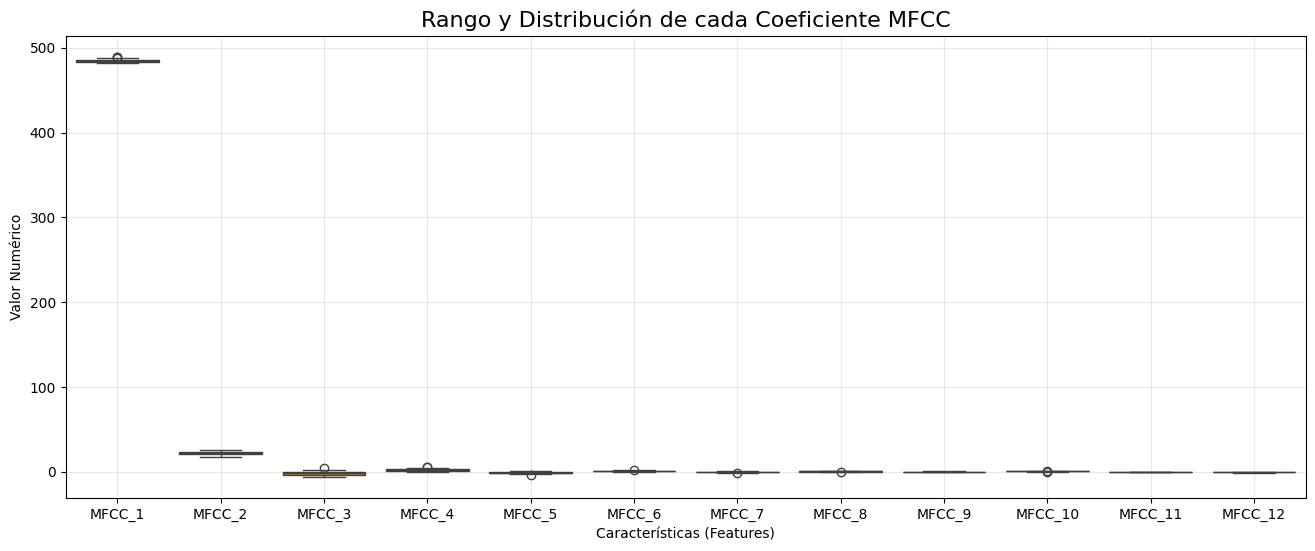

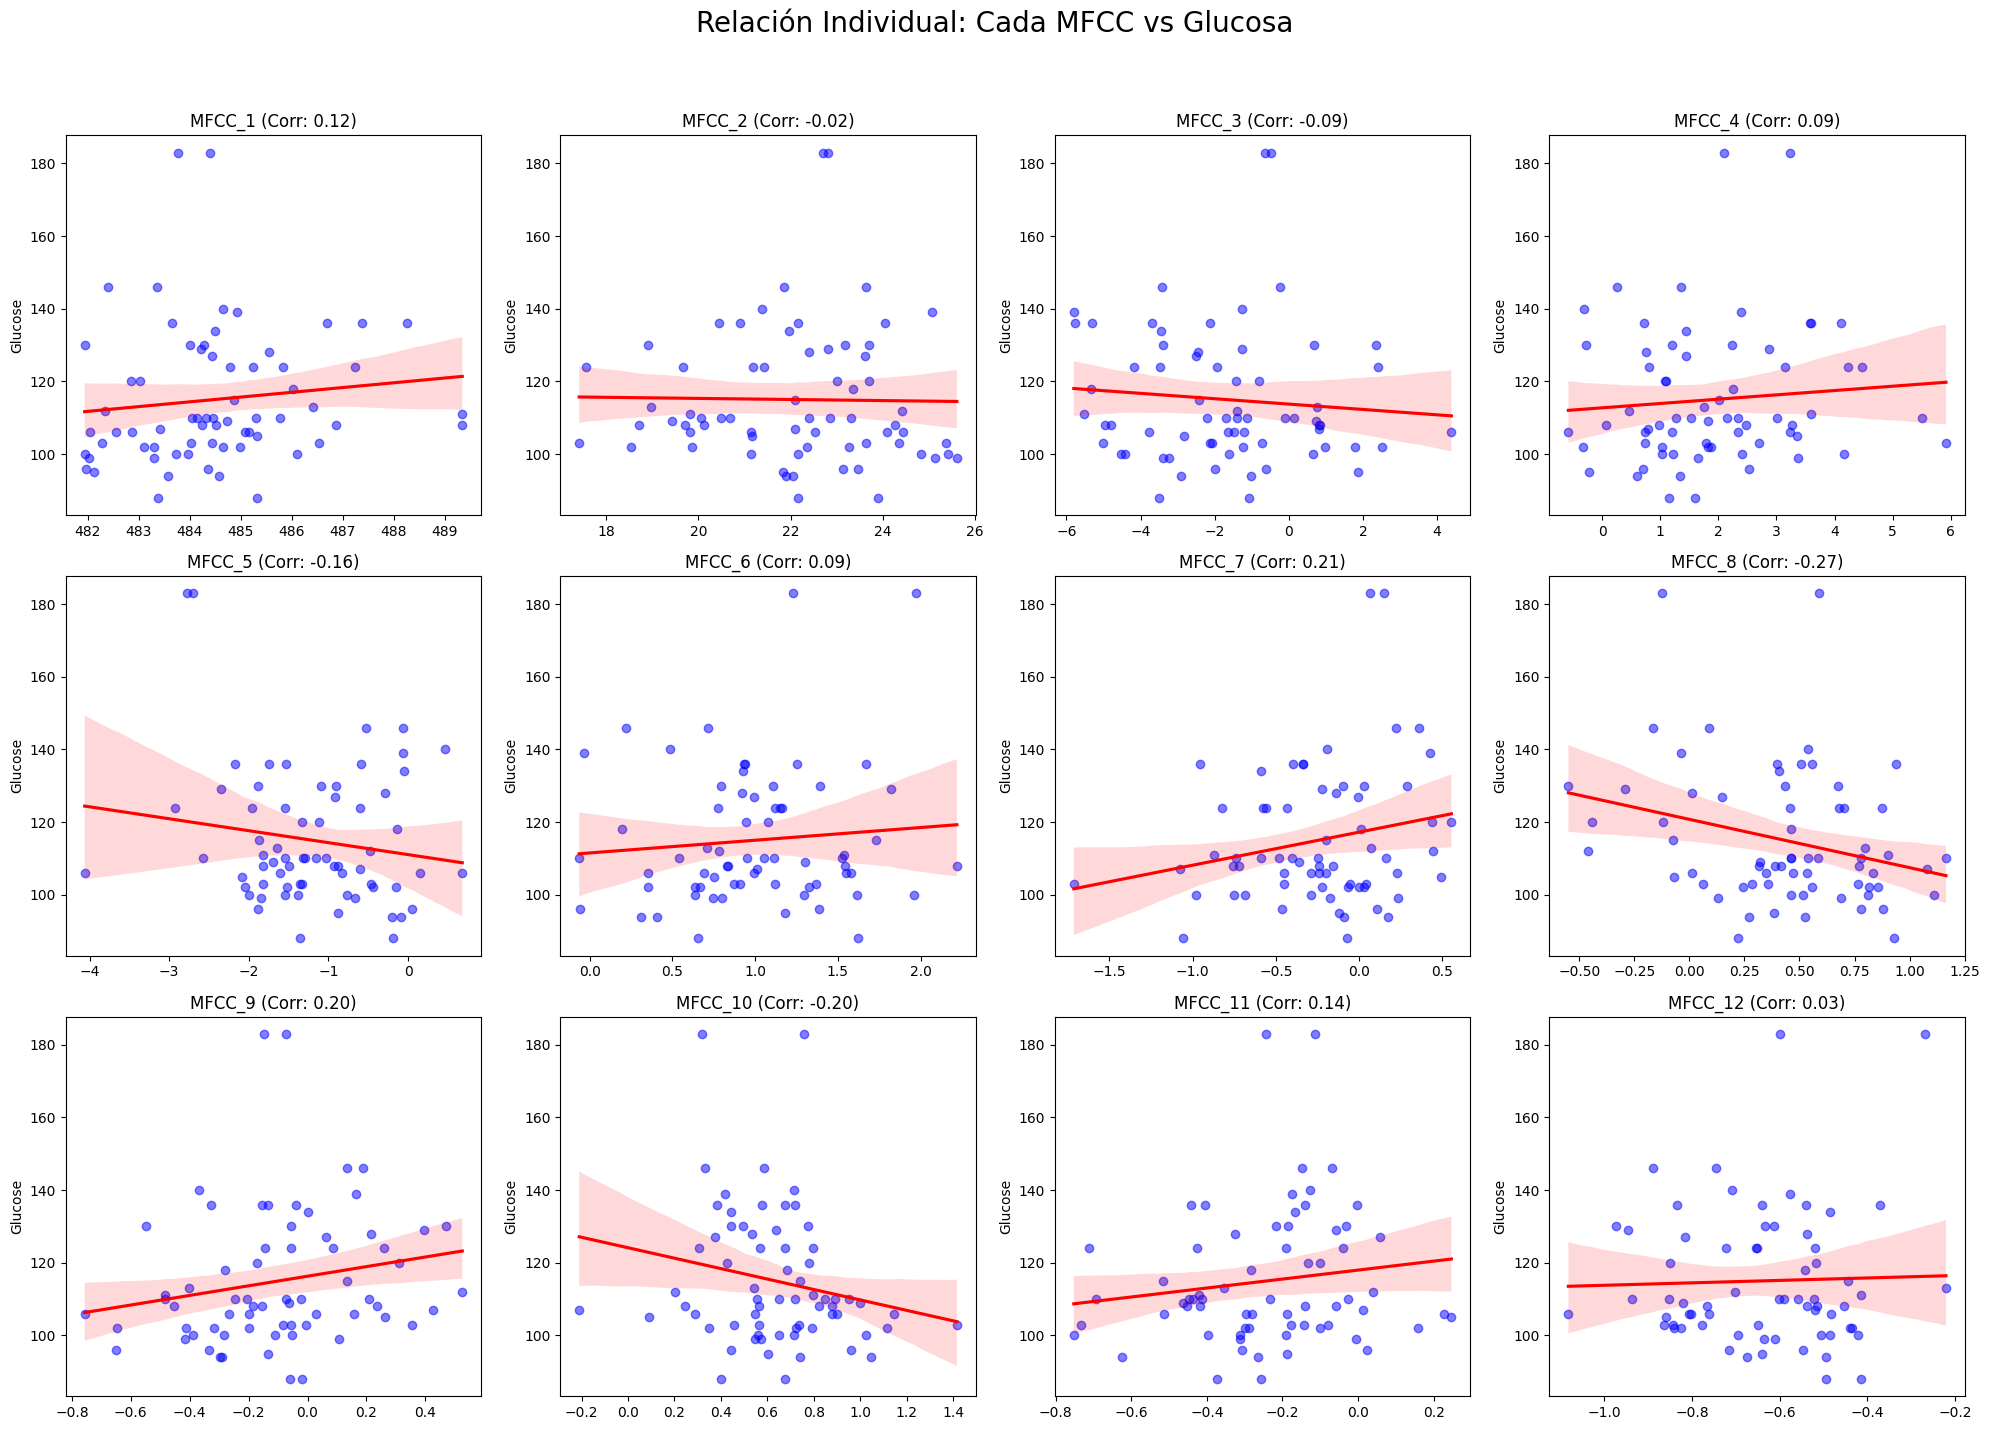

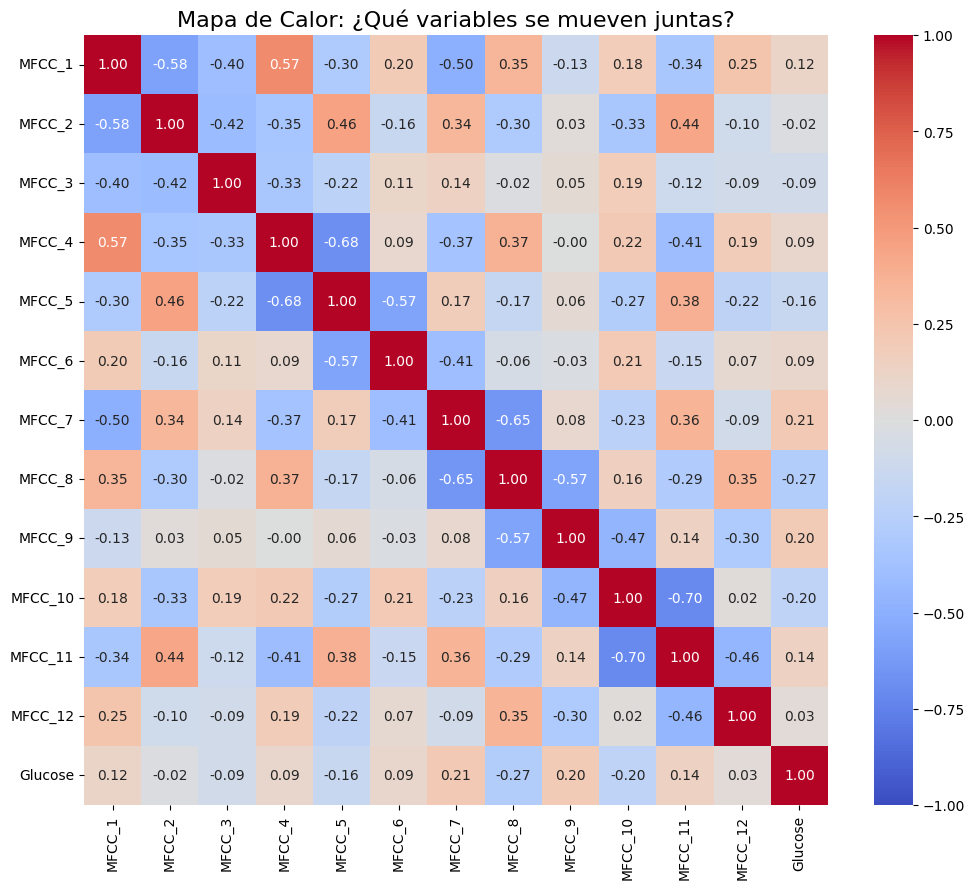

In [11]:
# ==========================================
# ANÁLISIS PROFUNDO DE CARACTERÍSTICAS (MFCC)
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Verificar si tenemos los datos cargados
if 'X' not in locals() or 'Y' not in locals():
    print("⚠️ ¡ALERTA! No se encuentran las variables X e Y.")
    print("Por favor, ejecuta la celda de 'Carga de Datos' (la que procesa los archivos signal_...) antes de ejecutar esta.")
else:
    print(f"Analizando características de {len(X)} muestras...")

    # 2. Crear un DataFrame para facilitar el análisis
    # Nombramos las columnas MFCC_1 hasta MFCC_12
    feature_names = [f'MFCC_{i+1}' for i in range(X.shape[1])]
    df_features = pd.DataFrame(X, columns=feature_names)
    df_features['Glucose'] = Y  # Añadimos la glucosa para comparar

    # --- A. ESTADÍSTICAS DESCRIPTIVAS ---
    print("\n--- Resumen Estadístico de las Características ---")
    # Mostramos transpuesta (.T) para leer mejor
    display(df_features.describe().T[['mean', 'std', 'min', 'max']])

    # --- B. VISUALIZACIÓN DE DISTRIBUCIONES (BOXPLOTS) ---
    # Los Boxplots son excelentes para ver outliers y el rango de valores
    plt.figure(figsize=(16, 6))
    sns.boxplot(data=df_features.drop(columns=['Glucose']))
    plt.title('Rango y Distribución de cada Coeficiente MFCC', fontsize=16)
    plt.xlabel('Características (Features)')
    plt.ylabel('Valor Numérico')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- C. ANÁLISIS INDIVIDUAL DE CADA FEATURE VS GLUCOSA ---
    # Vamos a graficar 12 pequeños gráficos de dispersión para ver si alguno forma una línea
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Relación Individual: Cada MFCC vs Glucosa', fontsize=20)

    axes = axes.flatten() # Aplanar para iterar fácil

    for i, col in enumerate(feature_names):
        # Scatter plot
        sns.regplot(x=df_features[col], y=df_features['Glucose'], ax=axes[i],
                    scatter_kws={'alpha':0.5, 'color':'blue'},
                    line_kws={'color':'red'})

        # Calcular correlación individual
        corr = df_features[col].corr(df_features['Glucose'])
        axes[i].set_title(f'{col} (Corr: {corr:.2f})', fontsize=12)
        axes[i].set_xlabel('') # Limpiar eje X para no saturar

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- D. HEATMAP DE CORRELACIÓN ---
    plt.figure(figsize=(12, 10))
    # Calculamos la matriz de correlación
    corr_matrix = df_features.corr()

    # Dibujamos
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
    plt.title('Mapa de Calor: ¿Qué variables se mueven juntas?', fontsize=16)
    plt.show()

Validación por Grupos lista. Total pacientes únicos: 23

Iniciando validación estricta (pacientes nunca vistos en test)...

--- RESULTADOS REALES (SIN DATA LEAKAGE) ---
RMSE: 19.54 mg/dL
Pearson: 0.0425
Zona A: 82.09%


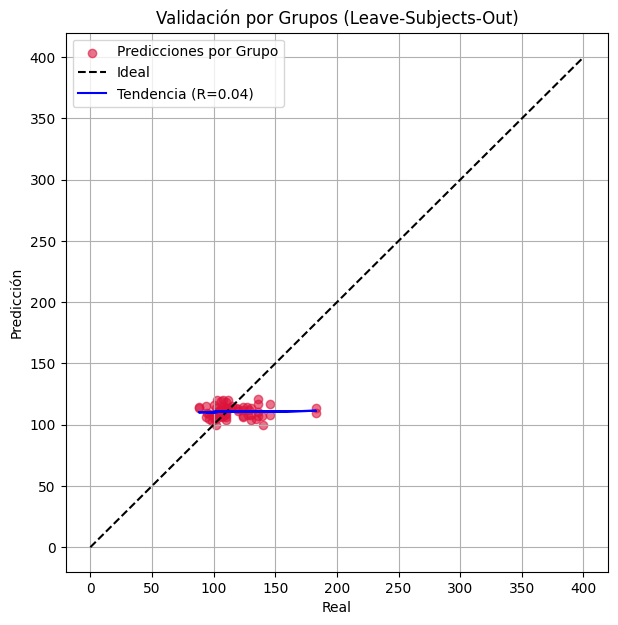

In [13]:
# ==========================================
# VALIDACIÓN CRUZADA POR GRUPOS (GROUP K-FOLD) - LA FORMA CORRECTA
# ==========================================
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# 1. RECONSTRUIR LA LISTA DE GRUPOS (IDs)
# Necesitamos saber a qué paciente (ID) pertenece cada fila de X.
# Repetimos la lógica de carga para asegurar que el orden coincida con X.

# Asumimos que la celda de carga ya se ejecutó y df_total existe, pero por seguridad:
if 'df_total' not in locals():
    # Cargar metadatos si no están en memoria
    RUTA_EN_DRIVE = '/content/drive/MyDrive/Colab Notebooks/MUST PPG'
    df_total = pd.read_csv(os.path.join(RUTA_EN_DRIVE, 'Total.csv'))
    df_total['measurement_num'] = df_total.groupby('ID').cumcount() + 1

groups = []
# Verificar archivos para alinear con X (que ya tienes cargado)
# IMPORTANTE: Esto asume que X e Y no han cambiado de orden desde la Celda 4
for index, row in df_total.iterrows():
    p_id = row['ID']
    m_num = row['measurement_num']
    file_name_base = f"signal_{p_id:02d}_{m_num:04d}"

    # Rutas posibles
    path_csv = os.path.join(RUTA_EN_DRIVE, file_name_base + ".csv")

    # Solo agregamos el grupo si el archivo existe (porque solo esos entraron en X)
    if os.path.exists(path_csv):
        # Leemos para verificar longitud (misma validación que celda 4)
        try:
            temp_df = pd.read_csv(path_csv, header=None)
            if len(temp_df) > 100:
                groups.append(p_id) # Guardamos el ID como identificador de grupo
        except:
            pass

groups = np.array(groups)

# Verificación de seguridad
if len(groups) != len(X):
    print(f"⚠️ ¡CUIDADO! Hay desajuste: {len(groups)} grupos vs {len(X)} muestras en X.")
    print("Por favor, vuelve a ejecutar la Celda 4 (Carga) y luego inmediatamente esta celda.")
else:
    print(f"Validación por Grupos lista. Total pacientes únicos: {len(np.unique(groups))}")

    # 2. CONFIGURAR GROUP K-FOLD
    # Usaremos 5 splits, asegurando que los pacientes no se mezclen
    gkf = GroupKFold(n_splits=5)

    y_real_gkf = []
    y_pred_gkf = []

    # Mejores hiperparámetros (del Grid Search anterior)
    best_C = 10
    best_gamma = 0.1
    best_epsilon = 0.1

    print("\nIniciando validación estricta (pacientes nunca vistos en test)...")

    fold = 1
    # NOTA: gkf.split requiere pasar 'groups'
    for train_idx, test_idx in gkf.split(X, Y, groups=groups):

        # Verificación: ¿Qué pacientes están en test?
        test_patients = np.unique(groups[test_idx])
        # print(f"Fold {fold}: Probando con pacientes {test_patients}")

        # Separar
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        # Escalar
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Entrenar
        svr = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon, gamma=best_gamma)
        svr.fit(X_train, y_train)

        # Predecir
        pred = svr.predict(X_test)

        y_real_gkf.extend(y_test)
        y_pred_gkf.extend(pred)
        fold += 1

    # 3. RESULTADOS HONESTOS
    y_real_arr = np.array(y_real_gkf)
    y_pred_arr = np.array(y_pred_gkf)

    rmse = np.sqrt(mean_squared_error(y_real_arr, y_pred_arr))
    corr, _ = pearsonr(y_real_arr, y_pred_arr)

    # Zona A
    diff_rel = np.abs((y_real_arr - y_pred_arr) / y_real_arr)
    zona_a = (np.sum(diff_rel <= 0.20) / len(y_real_arr)) * 100

    print(f"\n--- RESULTADOS REALES (SIN DATA LEAKAGE) ---")
    print(f"RMSE: {rmse:.2f} mg/dL")
    print(f"Pearson: {corr:.4f}")
    print(f"Zona A: {zona_a:.2f}%")

    # Gráfica
    plt.figure(figsize=(7, 7))
    plt.scatter(y_real_arr, y_pred_arr, c='crimson', alpha=0.6, label='Predicciones por Grupo')
    plt.plot([0, 400], [0, 400], 'k--', label='Ideal')

    # Regresión lineal de la predicción
    m, b = np.polyfit(y_real_arr, y_pred_arr, 1)
    plt.plot(y_real_arr, m*y_real_arr + b, 'b-', label=f'Tendencia (R={corr:.2f})')

    plt.title('Validación por Grupos (Leave-Subjects-Out)')
    plt.xlabel('Real')
    plt.ylabel('Predicción')
    plt.legend()
    plt.grid(True)
    plt.show()

Entrenando Random Forest con 67 muestras y 23 pacientes únicos...

--- RESULTADOS RANDOM FOREST (SIN DATA LEAKAGE) ---
RMSE: 21.20 mg/dL
Pearson: 0.0301
Zona A: 74.63%


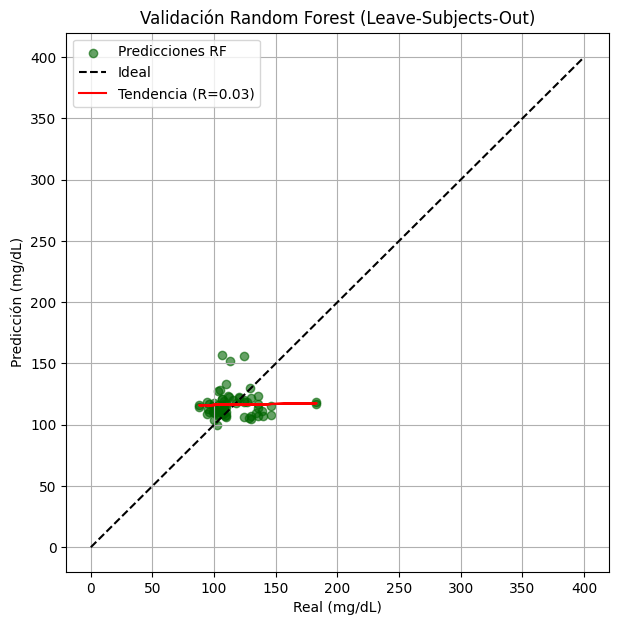


--- COMPARATIVA SVR vs RF ---
Mejora en RMSE: -1.66 mg/dL (Positivo es bueno)
Mejora en Pearson: -0.0125


In [14]:
# ==========================================
# CELDA 10: MODELO RANDOM FOREST (Group K-Fold)
# ==========================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# 1. Verificación de seguridad
if 'X' not in locals() or 'Y' not in locals() or 'groups' not in locals():
    print("⚠️ Error: Faltan datos. Por favor, ejecuta la celda de 'Validación por Grupos' (Celda anterior) para generar la variable 'groups'.")
else:
    print(f"Entrenando Random Forest con {len(X)} muestras y {len(np.unique(groups))} pacientes únicos...")

    # 2. Configuración del Modelo
    # Random Forest no necesita escalado de datos (StandardScaler), así que usamos X directo.
    # n_estimators=100: Número de árboles (estándar sólido)
    # max_depth=10: Limitamos profundidad para evitar memorizar el ruido (overfitting)
    rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)

    # 3. Validación Cruzada por Grupos (Estricta)
    gkf = GroupKFold(n_splits=5)

    y_real_rf = []
    y_pred_rf = []

    fold = 1
    for train_idx, test_idx in gkf.split(X, Y, groups=groups):
        # Separar (No escalamos)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        # Entrenar
        rf_model.fit(X_train, y_train)

        # Predecir
        pred = rf_model.predict(X_test)

        y_real_rf.extend(y_test)
        y_pred_rf.extend(pred)
        fold += 1

    # 4. Resultados
    y_real_arr = np.array(y_real_rf)
    y_pred_arr = np.array(y_pred_rf)

    rmse_rf = np.sqrt(mean_squared_error(y_real_arr, y_pred_arr))
    corr_rf, _ = pearsonr(y_real_arr, y_pred_arr)

    # Zona A
    diff_rel = np.abs((y_real_arr - y_pred_arr) / y_real_arr)
    zona_a_rf = (np.sum(diff_rel <= 0.20) / len(y_real_arr)) * 100

    print(f"\n--- RESULTADOS RANDOM FOREST (SIN DATA LEAKAGE) ---")
    print(f"RMSE: {rmse_rf:.2f} mg/dL")
    print(f"Pearson: {corr_rf:.4f}")
    print(f"Zona A: {zona_a_rf:.2f}%")

    # 5. Gráfica Comparativa
    plt.figure(figsize=(7, 7))
    plt.scatter(y_real_arr, y_pred_arr, c='darkgreen', alpha=0.6, label='Predicciones RF')

    # Línea ideal
    plt.plot([0, 400], [0, 400], 'k--', label='Ideal')

    # Tendencia lineal
    if len(np.unique(y_pred_arr)) > 1:
        m, b = np.polyfit(y_real_arr, y_pred_arr, 1)
        plt.plot(y_real_arr, m*y_real_arr + b, 'r-', label=f'Tendencia (R={corr_rf:.2f})')

    plt.title('Validación Random Forest (Leave-Subjects-Out)')
    plt.xlabel('Real (mg/dL)')
    plt.ylabel('Predicción (mg/dL)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Comparativa rápida con SVR anterior (si existe en memoria)
    if 'rmse' in locals(): # 'rmse' era la variable del SVR anterior
        print("\n--- COMPARATIVA SVR vs RF ---")
        print(f"Mejora en RMSE: {rmse - rmse_rf:.2f} mg/dL (Positivo es bueno)")
        print(f"Mejora en Pearson: {corr_rf - corr:.4f}")

/tmp/ipython-input-241551960.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Patient_ID', y=feature_name, data=df_analysis, order=sorted_idx, palette='viridis')


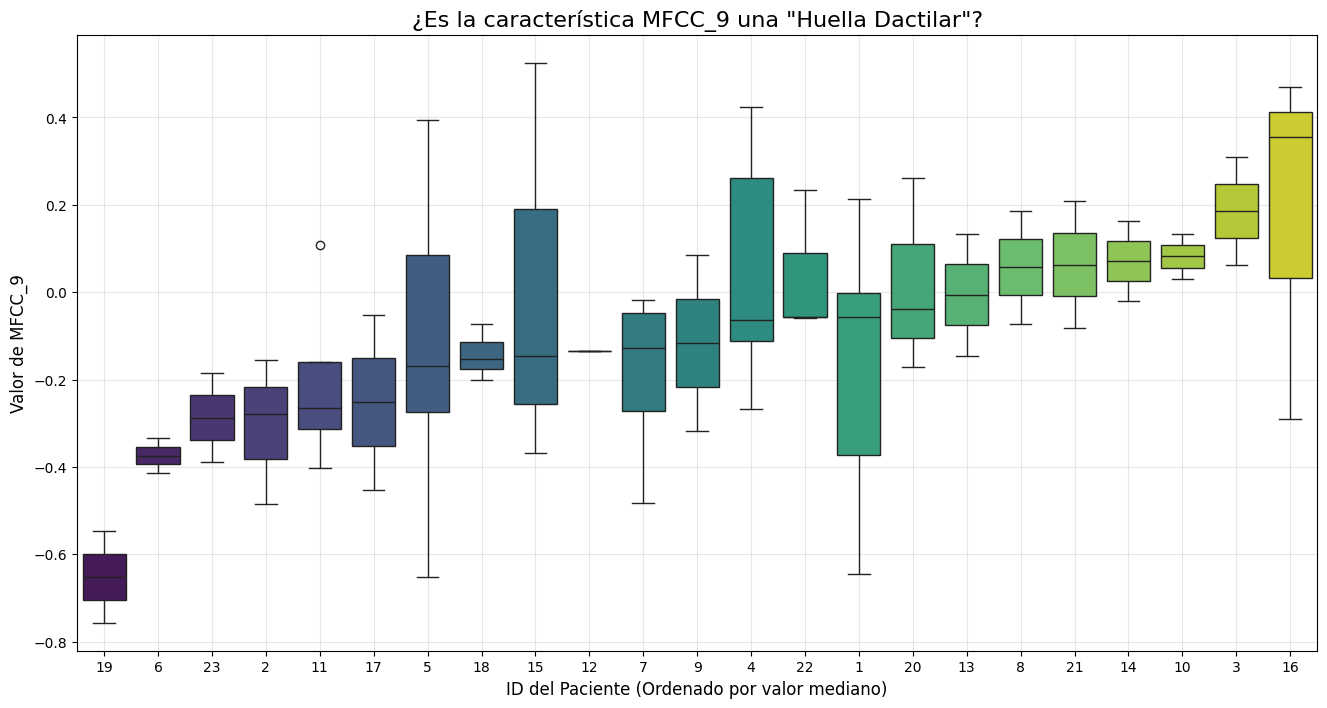

INTERPRETACIÓN:
- Si ves que cada paciente tiene su propia 'cajita' a una altura diferente,
  significa que la característica depende de la PERSONA, no de la glucosa.
- Para que funcionara como glucómetro universal, las cajas deberían estar alineadas
  o mezcladas, dependiendo solo de si la glucosa es alta o baja.


In [15]:
# ==========================================
# ANÁLISIS DE VARIABILIDAD POR PACIENTE
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Verificar datos
if 'X' in locals() and 'groups' in locals():

    # 1. Crear DataFrame con ID de paciente y una Feature clave
    # Usamos MFCC_9 (índice 8) porque fue la que mejor correlación mostró antes
    feature_idx = 8
    feature_name = f'MFCC_{feature_idx+1}'

    df_analysis = pd.DataFrame({
        'Patient_ID': groups,
        feature_name: X[:, feature_idx],
        'Glucose': Y
    })

    # 2. Gráfica: Distribución de la Feature por Paciente
    plt.figure(figsize=(16, 8))

    # Ordenamos por la mediana de la característica para ver el efecto "escalera"
    sorted_idx = df_analysis.groupby(['Patient_ID'])[feature_name].median().sort_values().index

    sns.boxplot(x='Patient_ID', y=feature_name, data=df_analysis, order=sorted_idx, palette='viridis')

    plt.title(f'¿Es la característica {feature_name} una "Huella Dactilar"?', fontsize=16)
    plt.xlabel('ID del Paciente (Ordenado por valor mediano)', fontsize=12)
    plt.ylabel(f'Valor de {feature_name}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    print("INTERPRETACIÓN:")
    print("- Si ves que cada paciente tiene su propia 'cajita' a una altura diferente,")
    print("  significa que la característica depende de la PERSONA, no de la glucosa.")
    print("- Para que funcionara como glucómetro universal, las cajas deberían estar alineadas")
    print("  o mezcladas, dependiendo solo de si la glucosa es alta o baja.")

else:
    print("Faltan datos X o groups.")